In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


In [56]:
batters = pd.read_csv('final_batters_df.csv')

In [57]:
batters.head().T

,0,1,2,3,4
row_id,ankieri01_2010,barajro01_2010,beltrad01_2010,berkmla01_2010,blumge01_2010
playerID,ankieri01,barajro01,beltrad01,berkmla01,blumge01
year,2010,2010,2010,2010,2010
position,OF,C,3B,1B,1B
age,31,35,31,34,37
avg_salary_year,3278746.825301,3278746.825301,3278746.825301,3278746.825301,3278746.825301
free_agent_salary,1500000.0,3250000.0,16000000.0,8000000.0,1350000.0
AB,996,1091,1594,1418,908
R,146,126,212,235,92
H,244,259,456,399,226


In [58]:
batters['won_mvp'] = batters['won_mvp'].astype('category')
batters['won_gold_glove'] = batters['won_gold_glove'].astype('category')
batters['won_cy_young'] = batters['won_cy_young'].astype('category')
batters['position'] = batters['position'].astype('category')
batters['won_silver_slugger'] = batters['won_silver_slugger'].astype('category')
batters['all_star'] = batters['all_star'].astype('category')

## Feature Selection - Lasso Regression

In [59]:
X = batters.drop(columns=["row_id", "playerID","year","free_agent_salary","ZR"])
y = batters["free_agent_salary"]
df_xy = pd.concat([X, y], axis=1)

df_xy = df_xy.dropna()

X = df_xy.drop(columns=[y.name])
y = df_xy[y.name]

In [60]:
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

In [61]:
alphas = np.logspace(-4, 4, 400)

In [62]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

In [63]:
lasso = Pipeline([
    ("prep", preprocess),
    ("scale", StandardScaler()),
    ("model", LassoCV(alphas=alphas, cv=10, random_state=0))
])

In [64]:
lasso.fit(X, y)

,steps,"[('prep', ...), ('scale', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


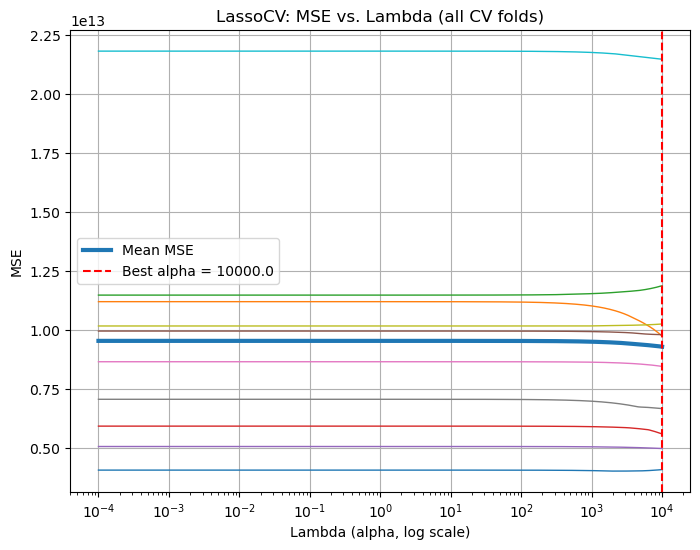

In [65]:

model = lasso.named_steps["model"]

alphas = model.alphas_
mse_path = model.mse_path_

plt.figure(figsize=(8,6))

for i in range(mse_path.shape[1]):
    plt.plot(alphas, mse_path[:, i], linewidth=1)

plt.plot(alphas, mse_path.mean(axis=1), linewidth=3, label='Mean MSE')

plt.axvline(model.alpha_, color='red', linestyle='--', label=f'Best alpha = {model.alpha_}')

plt.xscale('log')
plt.xlabel("Lambda (alpha, log scale)")
plt.ylabel("MSE")
plt.title("LassoCV: MSE vs. Lambda (all CV folds)")
plt.legend()
plt.grid(True)
plt.show()


In [66]:
# Build the feature names
num_original = list(num_cols)
num_squared = [f"{c}^2" for c in num_cols]

# Get OHE names
ohe = lasso.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()

all_features = num_original + cat_feature_names


In [67]:
coef = lasso.named_steps["model"].coef_

selected_features = [name for name, c in zip(all_features, coef) if c != 0]
selected_features
missing = [f for f in X if f not in selected_features]


In [68]:
missing

['position',
 '2B',
 'SB',
 'A',
 'WP',
 'SB.1',
 'won_cy_young',
 'won_mvp',
 'won_gold_glove',
 'won_silver_slugger',
 'all_star']

## Linear Regression

In [69]:
batters_clean = batters.dropna(subset=["free_agent_salary"])
X = batters_clean.drop(columns=["row_id", "playerID","year","free_agent_salary",
                          "ZR","position","2B","SB","A","WP","SB.1",
                          "won_cy_young","won_mvp","won_gold_glove","won_silver_slugger"])
y = batters_clean["free_agent_salary"]

# 2) Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Identify numeric and categorical columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# 4) Preprocessing pipeline (impute + OHE + scaling)
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0
)

full_pipeline = Pipeline([
    ("pre", preprocessor),
    ("scale", StandardScaler())
])

# 5) Fit pipeline on training data
full_pipeline.fit(X_train_raw)

# 6) Transform train and test sets
X_train_trans = full_pipeline.transform(X_train_raw)
X_test_trans  = full_pipeline.transform(X_test_raw)

# 7) Generate correct feature names
# numeric names
num_names = num_cols
# categorical names from OneHotEncoder
ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()

all_feature_names = num_names + cat_names

# 8) Convert transformed arrays to DataFrames with correct column names
X_train_df = pd.DataFrame(X_train_trans, columns=all_feature_names, index=X_train_raw.index)
X_test_df  = pd.DataFrame(X_test_trans,  columns=all_feature_names, index=X_test_raw.index)

# 9) Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train_df, y_train)

# 10) Predict and evaluate
y_pred = lr.predict(X_test_df)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.5f}")
print(f"Test R^2: {r2:.5f}")

# 11) Coefficient DataFrame
coef_df = pd.DataFrame({"feature": all_feature_names, "coefficient": lr.coef_})
print(coef_df.sort_values("coefficient", key=lambda s: s.abs(), ascending=False).head(20))

# 12) Optional: statsmodels OLS summary
X_train_sm = sm.add_constant(X_train_df)
ols_res = sm.OLS(y_train, X_train_sm).fit()
print(ols_res.summary())

Test MSE: 4858889123987.51074
Test R^2: 0.78859
            feature   coefficient
2                AB -7.832993e+06
4                 H  6.302647e+06
6                HR  2.574772e+06
21             CS.1  1.556493e+06
3                 R  1.118926e+06
5                3B  1.102756e+06
22       all_star_1  1.007133e+06
17               PO -9.983384e+05
1   avg_salary_year  9.541018e+05
16          InnOuts  8.897441e+05
18                E -8.163167e+05
19               DP  8.035198e+05
0               age -7.275222e+05
20               PB -6.025814e+05
10               SO -5.513189e+05
8                CS  4.506325e+05
9                BB  4.121028e+05
15             GIDP  3.341042e+05
7               RBI  3.113939e+05
13               SH -1.143949e+05
                            OLS Regression Results                            
Dep. Variable:      free_agent_salary   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.677
M